# Attention Scoring Functions
:label:`sec_attention-scoring-functions`


In :numref:`sec_attention-pooling`,
we used a number of different distance-based kernels, including a Gaussian kernel to model
interactions between queries and keys. As it turns out, distance functions are slightly more expensive to compute than dot products. As such, 
with the softmax operation to ensure nonnegative attention weights,
much of the work has gone into *attention scoring functions* $a$ in :eqref:`eq_softmax_attention` and :numref:`fig_attention_output` that are simpler to compute. 

![Computing the output of attention pooling as a weighted average of values, where weights are computed with the attention scoring function $\mathit{a}$ and the softmax operation.](../img/attention-output.svg)
:label:`fig_attention_output`


In [5]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## [**Dot Product Attention**]


Let's review the attention function (without exponentiation) from the Gaussian kernel for a moment:

$$
a(\mathbf{q}, \mathbf{k}_i) = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2  = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2  -\frac{1}{2} \|\mathbf{q}\|^2.
$$

First, note that the final term depends on $\mathbf{q}$ only. As such it is identical for all $(\mathbf{q}, \mathbf{k}_i)$ pairs. Normalizing the attention weights to $1$, as is done in :eqref:`eq_softmax_attention`, ensures that this term disappears entirely. Second, note that both batch and layer normalization (to be discussed later) lead to activations that have well-bounded, and often constant, norms $\|\mathbf{k}_i\|$. This is the case, for instance, whenever the keys $\mathbf{k}_i$ were generated by a layer norm. As such, we can drop it from the definition of $a$ without any major change in the outcome. 

Last, we need to keep the order of magnitude of the arguments in the exponential function under control. Assume that all the elements of the query $\mathbf{q} \in \mathbb{R}^d$ and the key $\mathbf{k}_i \in \mathbb{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$. To ensure that the variance of the dot product still remains $1$ regardless of vector length, we use the *scaled dot product attention* scoring function. That is, we rescale the dot product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used, e.g., in Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017`:

$$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.$$
:eqlabel:`eq_dot_product_attention`

Note that attention weights $\alpha$ still need normalizing. We can simplify this further via :eqref:`eq_softmax_attention` by using the softmax operation:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$$
:eqlabel:`eq_attn-scoring-alpha`

As it turns out, all popular attention mechanisms use the softmax, hence we will limit ourselves to that in the remainder of this chapter.

## Convenience Functions

We need a few functions to make the attention mechanism efficient to deploy. This includes tools for dealing with strings of variable lengths (common for natural language processing) and tools for efficient evaluation on minibatches (batch matrix multiplication). 


### [**Masked Softmax Operation**]

One of the most popular applications of the attention mechanism is to sequence models. Hence we need to be able to deal with sequences of different lengths. In some cases, such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences (see :numref:`sec_machine_translation` for an example). These special tokens do not carry meaning. For instance, assume that we have the following three sentences:

```
Dive  into  Deep    Learning 
Learn to    code    <blank>
Hello world <blank> <blank>
```

Since we do not want blanks in our attention model we simply need to limit $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ to $\sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ for however long, $l \leq n$, the actual sentence is. Since it is such a common problem, it has a name: the *masked softmax operation*. 

Let's implement it. Actually, the implementation cheats ever so slightly by setting the values of $\mathbf{v}_i$, for $i > l$, to zero. Moreover, it sets the attention weights to a large negative number, such as $-10^{6}$, in order to make their contribution to gradients and values vanish in practice. This is done since linear algebra kernels and operators are heavily optimized for GPUs and it is faster to be slightly wasteful in computation rather than to have code with conditional (if then else) statements.


In [1]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

To [**illustrate how this function works**],
consider a minibatch of two examples of size $2 \times 4$,
where their valid lengths are $2$ and $3$, respectively. 
As a result of the masked softmax operation,
values beyond the valid lengths for each pair of vectors are all masked as zero.


In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

NameError: name 'torch' is not defined

If we need more fine-grained control to specify the valid length for each of the two vectors of every example, we simply use a two-dimensional tensor of valid lengths. This yields:


In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

NameError: name 'torch' is not defined

### Batch Matrix Multiplication
:label:`subsec_batch_dot`

Another commonly used operation is to multiply batches of matrices by one another. This comes in handy when we have minibatches of queries, keys, and values. More specifically, assume that 

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}.
$$

Then the batch matrix multiplication (BMM) computes the elementwise product

$$\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$
:eqlabel:`eq_batch-matrix-mul`

Let's see this in action in a deep learning framework.


In [2]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

NameError: name 'torch' is not defined

## [**Scaled Dot Product Attention**]

Let's return to the dot product attention introduced in :eqref:`eq_dot_product_attention`. 
In general, it requires that both the query and the key
have the same vector length, say $d$, even though this can be addressed easily by replacing 
$\mathbf{q}^\top \mathbf{k}$ with $\mathbf{q}^\top \mathbf{M} \mathbf{k}$ where $\mathbf{M}$ is a matrix suitably chosen for translating between both spaces. For now assume that the dimensions match. 

In practice, we often think of minibatches for efficiency,
such as computing attention for $n$ queries and $m$ key-value pairs,
where queries and keys are of length $d$
and values are of length $v$. The scaled dot product attention 
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
thus can be written as 

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

Note that when applying this to a minibatch, we need the batch matrix multiplication introduced in :eqref:`eq_batch-matrix-mul`. In the following implementation of the scaled dot product attention,
we use dropout for model regularization.


In [8]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

To [**illustrate how the `DotProductAttention` class works**],
we use the same keys, values, and valid lengths from the earlier toy example for additive attention. For the purpose of our example we assume that we have a minibatch size of $2$, a total of $10$ keys and values, and that the dimensionality of the values is $4$. Lastly, we assume that the valid length per observation is $2$ and $6$ respectively. Given that, we expect the output to be a $2 \times 1 \times 4$ tensor, i.e., one row per example of the minibatch.


In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

Let's check whether the attention weights actually vanish for anything beyond the second and sixth column respectively (because of setting the valid length to $2$ and $6$).


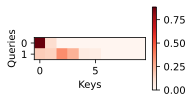

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**Additive Attention**]
:label:`subsec_additive-attention`

When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of different dimension,
we can either use a matrix to address the mismatch via $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, or we can use additive attention 
as the scoring function. Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings. 
Given a query $\mathbf{q} \in \mathbb{R}^q$
and a key $\mathbf{k} \in \mathbb{R}^k$,
the *additive attention* scoring function :cite:`Bahdanau.Cho.Bengio.2014` is given by 

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, 
and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization. 
An equivalent interpretation of :eqref:`eq_additive-attn` is that the query and key are concatenated
and fed into an MLP with a single hidden layer. 
Using $\tanh$ as the activation function and disabling bias terms, 
we implement additive attention as follows:


In [11]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let's [**see how `AdditiveAttention` works**]. In our toy example we pick queries, keys and values of size 
$(2, 1, 20)$, $(2, 10, 2)$ and $(2, 10, 4)$, respectively. This is identical to our choice for `DotProductAttention`, except that now the queries are $20$-dimensional. Likewise, we pick $(2, 6)$ as the valid lengths for the sequences in the minibatch.


In [12]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

f:\python3.10\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


When reviewing the attention function we see a behavior that is qualitatively quite similar to that of `DotProductAttention`. That is, only terms within the chosen valid length $(2, 6)$ are nonzero.


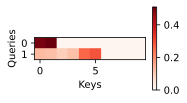

In [13]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Summary

In this section we introduced the two key attention scoring functions: dot product and additive attention. They are effective tools for aggregating across sequences of variable length. In particular, the dot product attention is the mainstay of modern Transformer architectures. When queries and keys are vectors of different lengths,
we can use the additive attention scoring function instead. Optimizing these layers is one of the key areas of advance in recent years. For instance, [NVIDIA's Transformer Library](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/index.html) and Megatron :cite:`shoeybi2019megatron` crucially rely on efficient variants of the attention mechanism. We will dive into this in quite a bit more detail as we review Transformers in later sections. 

## Exercises

1. Implement distance-based attention by modifying the `DotProductAttention` code. Note that you only need the squared norms of the keys $\|\mathbf{k}_i\|^2$ for an efficient implementation. 
1. Modify the dot product attention to allow for queries and keys of different dimensionalities by employing a matrix to adjust dimensions. 
1. How does the computational cost scale with the dimensionality of the keys, queries, values, and their number? What about the memory bandwidth requirements?


In [8]:
import torch
import torch.nn as nn
import math

class DistanceAttention(nn.Module):
    """Distance-based attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None, key_norms=None):
        """
        Args:
            queries (torch.Tensor): Tensor of shape (batch_size, no. of queries, d).
            keys (torch.Tensor): Tensor of shape (batch_size, no. of key-value pairs, d).
            values (torch.Tensor): Tensor of shape (batch_size, no. of key-value pairs, value dimension).
            valid_lens (torch.Tensor, optional): Tensor of shape (batch_size,) or (batch_size, no. of queries).
            key_norms (torch.Tensor, optional): Tensor of shape (batch_size, no. of key-value pairs) containing the squared norms of the keys.
        Returns:
            torch.Tensor: Tensor of shape (batch_size, no. of queries, value dimension).
        """
        if key_norms is None:
            key_norms = torch.sum(keys ** 2, dim=-1, keepdim=True)  # (batch_size, no. of key-value pairs, 1)
        
        # Compute the squared Euclidean distance between queries and keys
        distances = torch.sum((queries.unsqueeze(2) - keys.unsqueeze(1)) ** 2, dim=-1)  # (batch_size, no. of queries, no. of key-value pairs)
        
        # Apply the attention weights
        self.attention_weights = masked_softmax(-distances, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last dimension."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=shape[1], dim=0)
        else:
            valid_lens = valid_lens.reshape(-1)
        # Fill masked elements with a large negative value, whose exp will be 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

def sequence_mask(X, valid_lens, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_lens[:, None]
    X[~mask] = value
    return X

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DistanceAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

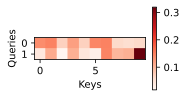

In [45]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [46]:
import torch.nn.functional as F

def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last dimension."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = valid_lens.repeat(shape[1], 1).transpose(0, 1)
        else:
            valid_lens = valid_lens.transpose(0, 1)
        # Fill masked elements with a large negative number, the negative large number
        # will be suppressed after software operation
        X_masked = X.clone()
        # very very important god damn
        # very very important god damn
        # very very important god damn
        # very very important god damn
        # very very important god damn
        # very very important god damn
        X_masked[~(torch.arange(X.size(1)).expand(len(valid_lens), X.size(1)) < valid_lens)] = float('-inf')
        return F.softmax(X_masked, dim=-1)
class DiffDimDotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, num_hiddens, dropout):
        super().__init__()
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        queries = self.W_q(queries)
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

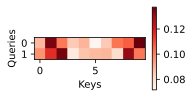

In [47]:
queries = torch.normal(0, 1, (2, 1, 10))
keys = torch.normal(0, 1, (2, 10, 3))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DiffDimDotProductAttention(keys.shape[-1], dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens).shape

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

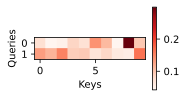

In [52]:
queries = torch.normal(0, 1, (2, 1, 10))
keys = torch.normal(0, 1, (2, 10, 3))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DiffDimDotProductAttention(keys.shape[-1], dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens).shape

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

[Discussions](https://discuss.d2l.ai/t/1064)
